In [13]:
import pandas as pd
import numpy as np
import os
import datetime
today = datetime.datetime.now().strftime("%Y%m%d")

# create a word cloud from the review comments
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from matplotlib.font_manager import FontProperties
import matplotlib.ticker as mtick
import string
import re
import os
import pandas as pd
import numpy as np
import spacy
import gc
font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')

In [8]:
graphicfolder = "./graphics"
if not os.path.exists(graphicfolder):
    os.makedirs(graphicfolder)

# Goal: understand the current application of ml in the urban study research
## Method:
1. Download all article abstracts from Webofscience: 1900 + articles
2. Visualize the temporal trend
3. Visualize the field categories

In [18]:
DF = pd.read_csv('data/abstracts-machine learning urban planning-20231203-1932rows.csv', index_col=0)
DF = DF[~DF['Abstract'].isna()].reset_index(drop = True)

In [30]:
#extract only reviews
en_stopwords = set(stopwords.words('english'))
def get_one_class(DF):
    # value is a list
    # temp = DF[DF[col].isin(value)].reset_index(drop = True)
    comments = DF['Abstract']
    comments = comments.astype('str')
    
    #function to remove non-ascii characters
    def _removeNonAscii(s): return "".join(i for i in s if ord(i)<128)
    #remove non-ascii characters
    comments = comments.map(lambda x: _removeNonAscii(x))
    print(comments.shape[0])
    #get stop words of all languages
    STOPWORDS_DICT = {lang: set(nltk.corpus.stopwords.words(lang)) for lang in nltk.corpus.stopwords.fileids()}
    #function to detect language based on # of stop words for particular language
    def get_language(text):
        words = set(nltk.wordpunct_tokenize(text.lower()))
        lang = max(((lang, len(words & stopwords)) for lang, stopwords in STOPWORDS_DICT.items()), key = lambda x: x[1])[0]
        if lang == 'english':
            return True
        else:
            return False
        
    return comments

def get_tokens(eng_comments):
    #load spacy
    nlp = spacy.load("en_core_web_sm")

    #function to clean and lemmatize comments
    def clean_comments(text):
        #remove punctuations
        regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
        nopunct = regex.sub(" ", str(text))
        #use spacy to lemmatize comments
        doc = nlp(nopunct, disable=['parser','ner'])
        lemma = [token.lemma_ for token in doc]
        return lemma

    #apply function to clean and lemmatize comments
    lemmatized = eng_comments.map(clean_comments)

    #make sure to lowercase everything
    lemmatized = lemmatized.map(lambda x: [word.lower() for word in x])

    #turn all comments' tokens into one single list
    unlist_comments = [item for items in lemmatized for item in items]
    return lemmatized, unlist_comments

def rightTypes(ngram, en_stopwords = en_stopwords):
    if '-pron-' in ngram or '' in ngram or ' 'in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in en_stopwords:
            return False
    acceptable_types = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in acceptable_types and tags[1][1] in second_type:
        return True
    else:
        return False
    
def rightTypesTri(ngram):
    if '-pron-' in ngram or '' in ngram or ' 'in ngram or '  ' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in en_stopwords:
            return False
    first_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    third_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in first_type and tags[2][1] in third_type:
        return True
    else:
        return False
def get_word_rank(DF, 
                  en_stopwords = en_stopwords):
    comments = get_one_class(DF)
    _, unlist_comments = get_tokens(comments)
    bigrams = nltk.collocations.BigramAssocMeasures()
    trigrams = nltk.collocations.TrigramAssocMeasures()
    bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(unlist_comments)
    trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(unlist_comments)

    #bigrams
    bigram_freq = bigramFinder.ngram_fd.items()
    bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)
    #trigrams
    trigram_freq = trigramFinder.ngram_fd.items()
    trigramFreqTable = pd.DataFrame(list(trigram_freq), columns=['trigram','freq']).sort_values(by='freq', ascending=False)
    
    filtered_bi = bigramFreqTable[bigramFreqTable.bigram.map(lambda x: rightTypes(x, en_stopwords))]
    # filtered_tri = trigramFreqTable[trigramFreqTable.trigram.map(lambda x: rightTypesTri(x, en_stopwords))]
    
    #filter for only those with more than 20 occurences
    bigramFinder.apply_freq_filter(20)
    # trigramFinder.apply_freq_filter(20)
    bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), 
                                columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)
    # trigramPMITable = pd.DataFrame(list(trigramFinder.score_ngrams(trigrams.pmi)), 
    #                             columns=['trigram','PMI']).sort_values(by='PMI', ascending=False)
    # merge the bigramPMITable and big
    mergedbig = filtered_bi.merge(bigramPMITable, on = 'bigram', how = 'inner')
    mergedbig['freqxPMI'] = mergedbig['freq'] * mergedbig['PMI']
    mergedbig = mergedbig.sort_values(by = 'freqxPMI', ascending = False)
    
    # merge the trigramPMITable and trig
    # mergedtri = filtered_tri.merge(trigramPMITable, on = 'trigram', how = 'inner')
    # mergedtri['freqxPMI'] = mergedtri['freq'] * mergedtri['PMI']
    # mergedtri = mergedtri.sort_values(by = 'freqxPMI', ascending = False)
    return mergedbig
# , mergedtri


In [40]:
dropwords = [
    'smart city',
 'real time',
 'result show',
 'e g',
 'neural network',
 'case study',
 'artificial intelligence',
 'deep learning',
 'long term',
 'degree c',
 'experimental result',
 'large scale',
 'elsevi ltd',
 'real world',
 'g   ',
 'paper present',
 'decision make',
 'b v',
 'elsevi b',
 'study indicate',
 'propose method',
 'paper propose',
 'result indicate',
 'machine learning',
 'support vector',
 'natural language',
 'language processing',
 'e   ',
 'recent year',
 'previous literature',
 'propose system',
 'smart mobility',
 'smart transportation',
 'propose technology',
 'ai technique',
 'ai base',
 'linear regression',
 'artificial neural',
 'artificial intelligence',
 'deep neural',
 'simulation result',
 'propose approach',
 'p   ',
 'result demonstrate',
 'vector machine',
 'machine learn',
 'ai model',
 'neural network',
 'propose model',
 "study aim",
 "ai technology",
    "ai algorithm",
    "reinforcement learning",
    "computer vision",
    "high accuracy",
    "intelligence technology",
    "intelligence base",
    "future research",
    "prediction model",
    "training datum",
    "ai application",
    "high level",
    "ai system",
    "base model",
    "state of art",
    "time series",
    "high quality",
    "literature review",
    "systematic review",
    "optimization algorithm",
    "datum set",
    "ai method",
    "base method",
    "network model",
    "mean square",
    "least square",
    "wide range",
    "f1 score",
    "datum analysis",
    "ad hoc",
    "rapid development",
    "learning technique",
    "genetic algorithm",
    "ai system",
    "base approach",
    "decision tree",
    "short term",
    "extensive experiment",
    "root mean",
    "high performance",
    "big datum",
    "control group",
    "focus group",
    "control algorithm",
    "smart economy",
    "include study",
    "case study",
    "enable technology",
    "comparative analysis",
    "spatial temporal",
    "bad case",
    "general intelligence",
    "include study",
    "factor analysis",
    "confidence interval",
    "new approach",
    "mu g",
    "mu l",
    "mg l",
    "use case",
    "use cases",
    "smart governance",
    "large number",
    "pilot study",
    "new zealand",
    "czech republic",
    "mixed methodology",
    "v2 g",
    "gradient boost",
    "kalman filter",
    "open source",
    "paper aim",
    'smart mobility',
    "elsevi inc",
    "hidden markov",
    "optical flow",
    "true test",
    "nc nd",
    "rf emf",
    "t2 dm",
    "monte carlo",
    "fine grain",
    "multi agent",
    "third party",
    "g l",
    "g ml",
    "g c3n4",
    "vertical bar",
    'ocp ua', 'dc dc', 'li ion',
    "dc converter", "opc ua",
    "datum drive",
    "data drive",
    "intelligence algorithm",
    "intelligence technique",
    "datum drive",
    "data drive",
    "intelligence algorithm",
    "intelligence technique",
    "model base",
    "model use",
    "square error",
    "use ai",
    "use model",
    "method base",
    "learn algorithm",
    "time consume",
    "polish city"
]

In [31]:
mergedbig= get_word_rank(DF)

1931


In [36]:
mergedbig['text'] = mergedbig['bigram'].map(lambda x: ' '.join(x))
taskdict = dict(zip(mergedbig['text'], mergedbig['freqxPMI']))

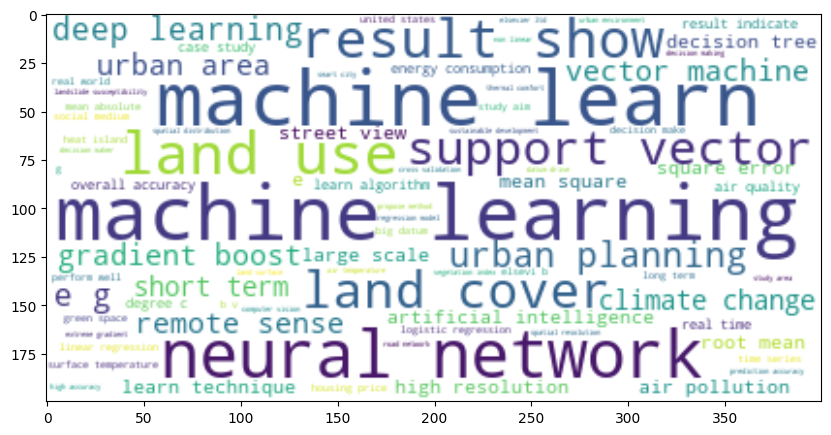

In [37]:
# create wordcloud using the taskdict
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white",prefer_horizontal=1, )
wordcloud.fit_words(taskdict)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Drop all buzz words

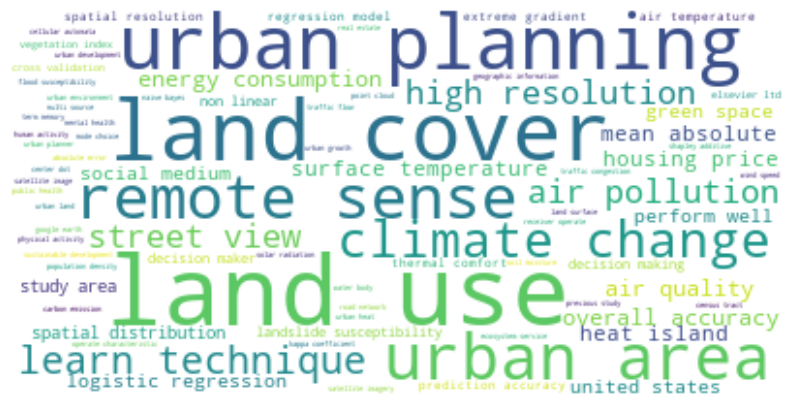

In [41]:
mergedbig_update = mergedbig[~mergedbig['text'].isin(dropwords)].reset_index(drop = True)
taskdict = dict(zip(mergedbig_update['text'], mergedbig_update['freqxPMI']))

# create wordcloud using the taskdict
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white",prefer_horizontal=1, )
wordcloud.fit_words(taskdict)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()